In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [13]:
df = pd.read_excel('RJ_Reconstrucao_Moluscos_2024_06_06.xlsx')
print(df.head())

    Ano  Lula_art  Lula_ind  Lula_art_ind  Lula_oceanica_art  Calamar_ind  \
0  1950       NaN       NaN           NaN                NaN          NaN   
1  1951       NaN       NaN           NaN                NaN          NaN   
2  1952       NaN       NaN           NaN                NaN          NaN   
3  1953       NaN       NaN           NaN                NaN          NaN   
4  1954       NaN       NaN           NaN                NaN          NaN   

   Polvo_art  Polvo_ind  Polvo_art_ind  Polvo_cabecinha_art  ...  \
0        NaN        NaN            NaN                  NaN  ...   
1        NaN        NaN            NaN                  NaN  ...   
2        NaN        NaN            NaN                  NaN  ...   
3        NaN        NaN            NaN                  NaN  ...   
4        NaN        NaN            NaN                  NaN  ...   

   Mexilhao_art  Mexilhao_ind  Mexilhao_mangue_art  Caramujo_art  \
0           NaN           NaN                  NaN          

In [11]:
x0 = df[['Ano', 'Polvo_art']].dropna().values
x1 = df[['Ano', 'Polvo_ind']].dropna().values


In [15]:
df_x0= pd.DataFrame(x0, columns= ['Ano', 'Polvo_art'])
df_x1=pd.DataFrame(x1, columns= ['Ano', 'Polvo_ind'])
df_x0= df_x0.drop_duplicates(subset= 'Polvo_art')
df_x1= df_x1.drop_duplicates(subset='Polvo_ind')

In [17]:
x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Polvo_art'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

In [18]:
def leaky_relu(x):
    return tf.nn.RMSprop(x, alpha=0.01)

Epoch 1/1000


C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 154us/step - loss: 0.5057 - mse: 0.9915
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4994 - mse: 0.9793
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - loss: 0.4977 - mse: 0.9759
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - loss: 0.4949 - mse: 0.9704
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - loss: 0.4931 - mse: 0.9669
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - loss: 0.4921 - mse: 0.9649
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 72us/step - loss: 0.4910 - mse: 0.9628
Epoch 8/1000
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9612 - mse: 0.9612

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 0.4902 - mse: 0.9612
Epoch 9/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - loss: 0.4895 - mse: 0.9598
Epoch 10/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4889 - mse: 0.9586
Epoch 11/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - loss: 0.4880 - mse: 0.9568
Epoch 12/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - loss: 0.4871 - mse: 0.9551
Epoch 13/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4861 - mse: 0.9531
Epoch 14/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - loss: 0.4849 - mse: 0.9508
Epoch 15/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - loss: 0.4837 - mse: 0.9484
Epoch 16/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 72us/step - loss: 0.4822 - mse: 0.9456
Epoch 17/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4807 - mse: 0.9425
Epoch 18/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - loss: 0.4790 - mse: 0.9393
Epoch 19/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.4774 - mse: 0.9360
Epoch 20/1000
50

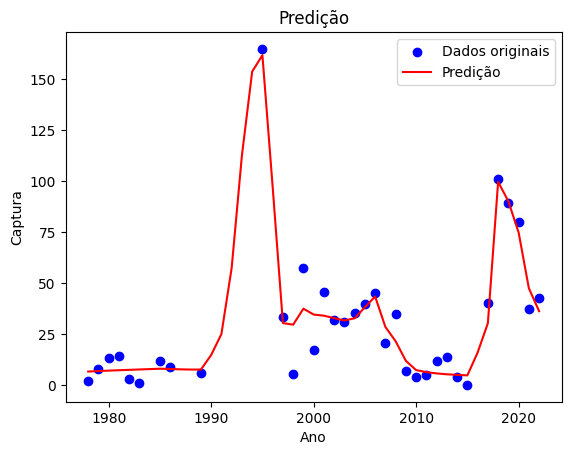

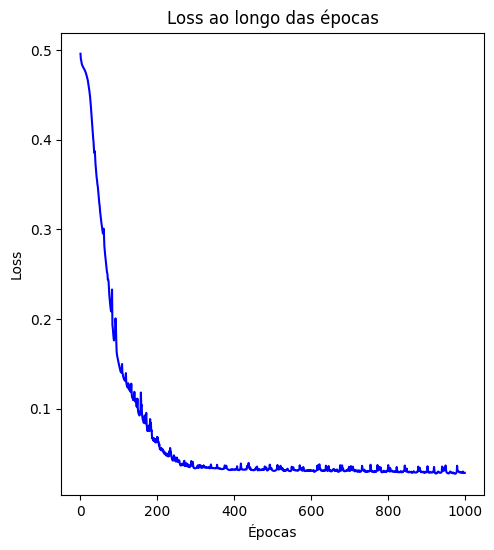

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])


history = model.fit(x_normalized, y_normalized, epochs= 1000, batch_size= 64, steps_per_epoch= 50, verbose=True)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predição para o ano 1969: 4.424816131591797
Predição para o ano 1970: 4.669778823852539
Predição para o ano 1971: 4.914743423461914
Predição para o ano 1972: 5.159685134887695
Predição para o ano 1973: 5.4046478271484375
Predição para o ano 1974: 5.650201797485352
Predição para o ano 1975: 5.886768341064453
Predição para o ano 1976: 6.115287780761719
Predição para o ano 1977: 6.343820571899414
Predição para o ano 1990: 14.702425003051758
Predição para o ano 1991: 25.00455093383789
Predição para o ano 1992: 57.47578430175781
Predição para o ano 1993: 112.69287872314453
Predição para o ano 1994: 153.85702514648438
Predição para o ano 2016: 15.886758804321289


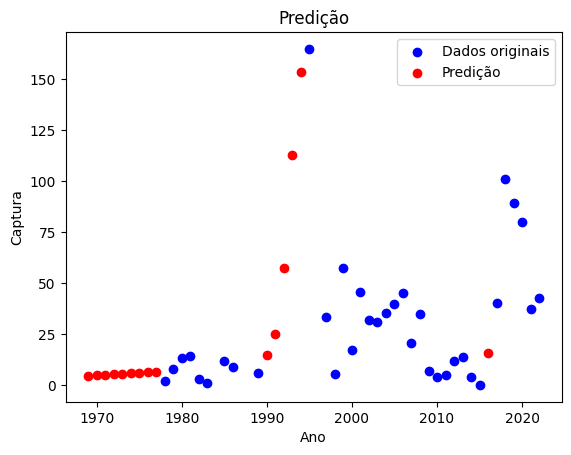

In [26]:
anos_para_prever = np.array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1990, 1991, 1992, 1993, 1994, 2016]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='outer').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.scatter(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição')
plt.legend()
plt.show()

In [31]:
df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
print(df_combined)
df_combined.to_excel('DataFrame_reconstruido/Polvo_artesanal_reconstruido.xlsx', index=False)

       Ano  Captura Original  Captura Preditos
0   1969.0               NaN          4.424816
1   1970.0               NaN          4.669779
2   1971.0               NaN          4.914743
3   1972.0               NaN          5.159685
4   1973.0               NaN          5.404648
5   1974.0               NaN          5.650202
6   1975.0               NaN          5.886768
7   1976.0               NaN          6.115288
8   1977.0               NaN          6.343821
9   1978.0          2.000000               NaN
10  1979.0          8.000000               NaN
11  1980.0         13.000000               NaN
12  1981.0         14.000000               NaN
13  1982.0          3.000000               NaN
14  1983.0          1.000000               NaN
15  1985.0         12.000000               NaN
16  1986.0          9.000000               NaN
17  1989.0          6.000000               NaN
18  1990.0               NaN         14.702425
19  1991.0               NaN         25.004551
20  1992.0   

FileNotFoundError: [Errno 2] No such file or directory: 'DataFrame_reconstruido/Polvo_artesanal_reconstruido.xlsx'